In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Correct import for RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

In [ ]:


# Load the data files
train_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\train.csv", low_memory=False)
test_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\test.csv", low_memory=False)
sample_submission_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\sample_submission.csv")


In [ ]:
# Define a data cleaning function
def data_cleaning(nba_df):
    # Separate numeric and non-numeric columns
    numeric_cols = nba_df.select_dtypes(include=['number']).columns
    object_cols = nba_df.select_dtypes(include=['object']).columns

    # Fill missing values for numeric columns using median
    nba_df[numeric_cols] = nba_df[numeric_cols].fillna(nba_df[numeric_cols].median())

    # Convert categorical columns to numeric codes
    for col in object_cols:
        nba_df[col] = nba_df[col].astype('category').cat.codes

    return nba_df

# Clean the train and test datasets
train_df_cleaned = data_cleaning(train_df)
test_df_cleaned = data_cleaning(test_df)


In [ ]:
# Define features (X) and target (y)
X = train_df_cleaned.drop(columns=['drafted'])
y = train_df_cleaned['drafted'].astype(int)

# Prepare test features
X_test = test_df_cleaned


Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 fe

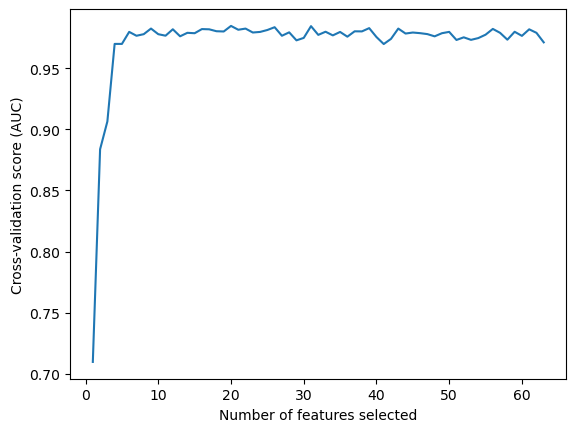

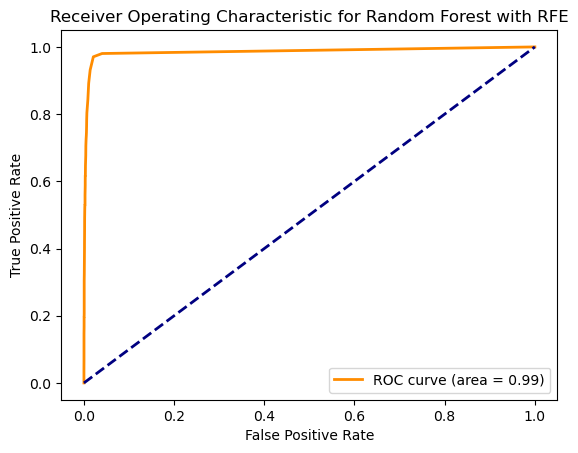

Submission file 'rf_submission.csv' created successfully!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the data files
train_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\train.csv", low_memory=False)
test_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\test.csv", low_memory=False)

# Data Cleaning Function
def data_cleaning(nba_df):
    numeric_cols = nba_df.select_dtypes(include=['number']).columns
    object_cols = nba_df.select_dtypes(include=['object']).columns

    nba_df[numeric_cols] = nba_df[numeric_cols].fillna(nba_df[numeric_cols].median())
    for col in object_cols:
        nba_df[col] = nba_df[col].astype('category').cat.codes

    return nba_df

# Clean the datasets
train_df_cleaned = data_cleaning(train_df)
test_df_cleaned = data_cleaning(test_df)

# Define features (X) and target (y) for training
X = train_df_cleaned.drop(columns=['drafted'])
y = train_df_cleaned['drafted'].astype(int)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')

# Use RFECV for feature selection
rfecv = RFECV(estimator=rf_model, step=1, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

# Plot the number of features vs. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (AUC)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Retrain the Random Forest model using only the selected features
X_train_rfe = X_train.iloc[:, rfecv.support_]
X_val_rfe = X_val.iloc[:, rfecv.support_]
rf_model.fit(X_train_rfe, y_train)

# Predict probabilities on the validation set
val_probs_rf = rf_model.predict_proba(X_val_rfe)[:, 1]

# Evaluate using ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, val_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest with RFE')
plt.legend(loc="lower right")
plt.show()

# Prepare the test set with selected features
X_test_rfe = test_df_cleaned[X_train.columns[rfecv.support_]]

# Predict probabilities on the test set
test_probs_rf = rf_model.predict_proba(X_test_rfe)[:, 1]

# Save the predictions
submission_df = pd.DataFrame({'player_id': test_df['player_id'], 'drafted': test_probs_rf})
submission_df.to_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\rf_submission.csv", index=False)

print("Submission file 'rf_submission.csv' created successfully!")
